In [87]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

## Часть 1. Игрушечный набор данных "девушка в баре"
Цель – "на пальцах", с помощью игрушечной задачи классификации разобраться в том, как работают деревья решений. Само по себе дерево решений – довольно слабый алгоритм, но основанные на нем алгоритмы случайного леса и градиентного бустинга - пожалуй, лучшее, что есть на сегодняшний день (в задачах, где можно обойтись без нейронных сетей). Поэтому разобраться в том, как работает дерево решений, полезно.

Рассмотрим игрушечную задачу бинарной классификации: поедет ли с Вами девушка из бара? Это будет зависеть от Вашей внешности и красноречия, крепости предлагаемых напитков и, как это ни меркантильно, от количества потраченных в баре денег.

In [2]:
# Создание датафрейма с dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis = 1)
    out.drop(feature_list, axis = 1, inplace = True)
    return out

# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
def intersect_features(train, test):
    common_feat = list( set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [3]:
features = ['Внешность', 'Алкоголь_в_напитке',
            'Уровень_красноречия', 'Потраченные_деньги']

### Обучающая выборка

In [4]:
df_train = {}
df_train['Внешность'] = ['приятная', 'приятная', 'приятная', 'отталкивающая',
                         'отталкивающая', 'отталкивающая', 'приятная'] 
df_train['Алкоголь_в_напитке'] = ['да', 'да', 'нет', 'нет', 'да', 'да', 'да']
df_train['Уровень_красноречия'] = ['высокий', 'низкий', 'средний', 'средний', 'низкий',
                                   'высокий', 'средний']
df_train['Потраченные_деньги'] = ['много', 'мало', 'много', 'мало', 'много',
                                  'много', 'много']
df_train['Поедет'] = LabelEncoder().fit_transform(['+', '-', '+', '-', '-', '+', '+'])

df_train = create_df(df_train, features)
df_train

,Поедет,Внешность_отталкивающая,Внешность_приятная,Алкоголь_в_напитке_да,Алкоголь_в_напитке_нет,Уровень_красноречия_высокий,Уровень_красноречия_низкий,Уровень_красноречия_средний,Потраченные_деньги_мало,Потраченные_деньги_много
0,0,0,1,1,0,1,0,0,0,1
1,1,0,1,1,0,0,1,0,1,0
2,0,0,1,0,1,0,0,1,0,1
3,1,1,0,0,1,0,0,1,1,0
4,1,1,0,1,0,0,1,0,0,1
5,0,1,0,1,0,1,0,0,0,1
6,0,0,1,1,0,0,0,1,0,1


## Тестовая выборка

In [5]:
df_test = {}
df_test['Внешность'] = ['приятная', 'приятная', 'отталкивающая'] 
df_test['Алкоголь_в_напитке'] = ['нет', 'да', 'да']
df_test['Уровень_красноречия'] = ['средний', 'высокий', 'средний']
df_test['Потраченные_деньги'] = ['много', 'мало', 'много']
df_test = create_df(df_test, features)
df_test

,Внешность_отталкивающая,Внешность_приятная,Алкоголь_в_напитке_да,Алкоголь_в_напитке_нет,Уровень_красноречия_высокий,Уровень_красноречия_средний,Потраченные_деньги_мало,Потраченные_деньги_много
0,0,1,0,1,0,1,0,1
1,0,1,1,0,1,0,1,0
2,1,0,1,0,0,1,0,1


In [6]:
# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
y = df_train['Поедет']
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Уровень_красноречия_высокий,Алкоголь_в_напитке_нет,Потраченные_деньги_много,Алкоголь_в_напитке_да,Внешность_приятная,Уровень_красноречия_средний,Потраченные_деньги_мало,Внешность_отталкивающая
0,1,0,1,1,1,0,0,0
1,0,0,0,1,1,0,1,0
2,0,1,1,0,1,1,0,0
3,0,1,0,0,0,1,1,1
4,0,0,1,1,0,0,0,1
5,1,0,1,1,0,0,0,1
6,0,0,1,1,1,1,0,0


In [7]:
df_test

,Уровень_красноречия_высокий,Алкоголь_в_напитке_нет,Потраченные_деньги_много,Алкоголь_в_напитке_да,Внешность_приятная,Уровень_красноречия_средний,Потраченные_деньги_мало,Внешность_отталкивающая
0,0,1,1,0,1,1,0,0
1,1,0,0,1,1,0,1,0
2,0,0,1,1,0,1,0,1


Постройте с помощью sklearn дерево решений, обучив его на обучающей выборке. Глубину можно не ограничивать.

In [8]:
tree = DecisionTreeClassifier(max_depth=5)

tree.fit(df_train, y)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

[Text(200.88000000000002, 190.26, 'X[6] <= 0.5\ngini = 0.49\nsamples = 7\nvalue = [4, 3]'),
 Text(133.92000000000002, 135.9, 'X[7] <= 0.5\ngini = 0.32\nsamples = 5\nvalue = [4, 1]'),
 Text(66.96000000000001, 81.53999999999999, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(200.88000000000002, 81.53999999999999, 'X[0] <= 0.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(133.92000000000002, 27.180000000000007, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(267.84000000000003, 27.180000000000007, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(267.84000000000003, 135.9, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]')]

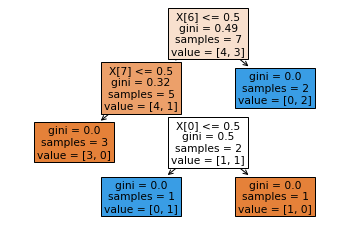

In [9]:
plot_tree(tree, filled=True)

## Часть 2. Функции для расчета энтропии и прироста информации
Примерчик для проверки: 9 синих шариков и 11 желтых. Пусть шарик находится в состоянии "1", если он синий и "0" – если он желтый.

In [10]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

Дальше пусть шарики разбиваются на 2 группы

In [11]:
balls_left  = [1 for i in range(8)] + [0 for i in range(5)] # 8 синих и 5 желтых
balls_right = [1 for i in range(1)] + [0 for i in range(6)] # 1 синий и 6 желтых

Реализуйте функцию для расчета энтропии Шеннона.

In [12]:
from math import log2

def entropy(a_list):
    total = len(a_list)
    blue = a_list.count(1)
    yellow = total - blue
    return -blue/total * log2(blue/total) - yellow/total * log2(yellow/total)

In [13]:
print(entropy(balls)) # 9 синих и 11 желтых
print(entropy(balls_left)) # 8 синих и 5 желтых
print(entropy(balls_right)) # 1 синий и 6 желтых
print(entropy([1,2,3,4,5,6])) # энтропия игральной кости с несмещенным центром тяжести

0.9927744539878084
0.961236604722876
0.5916727785823275
0.6500224216483541


Прирост информации

In [14]:
def information_gain(root, left, right):
    root_s = enthropy(balls)
    left_s = len(left)/len(root) * entropy(left)
    right_s = len(right)/len(root) * entropy(right)
    return root_s - left_s - right_s    

## Часть 3. Набор данных "Adult"

In [31]:
colnames = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capial-loss',
           'hours-per-week', 'native-country', 'salary']
df = pd.read_csv('adult.data.csv', names=colnames, header=None, skipinitialspace=True)

In [32]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capial-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capial-loss       32561 non-null int64
hours-per-week    32561 non-null int64
native-country    32561 non-null object
salary            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


### Первичный анализ данных.

In [34]:
df['fnlwgt'] = df['fnlwgt'].astype(int)
df['education-num'] = df['education-num'].astype(int)
df['capital-gain'] = df['capital-gain'].astype(int)
df['capial-loss'] = df['capial-loss'].astype(int)
df['hours-per-week'] = df['hours-per-week'].astype(int)

In [35]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capial-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int32
education         32561 non-null object
education-num     32561 non-null int32
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int32
capial-loss       32561 non-null int32
hours-per-week    32561 non-null int32
native-country    32561 non-null object
salary            32561 non-null object
dtypes: int32(5), int64(1), object(9)
memory usage: 3.1+ MB


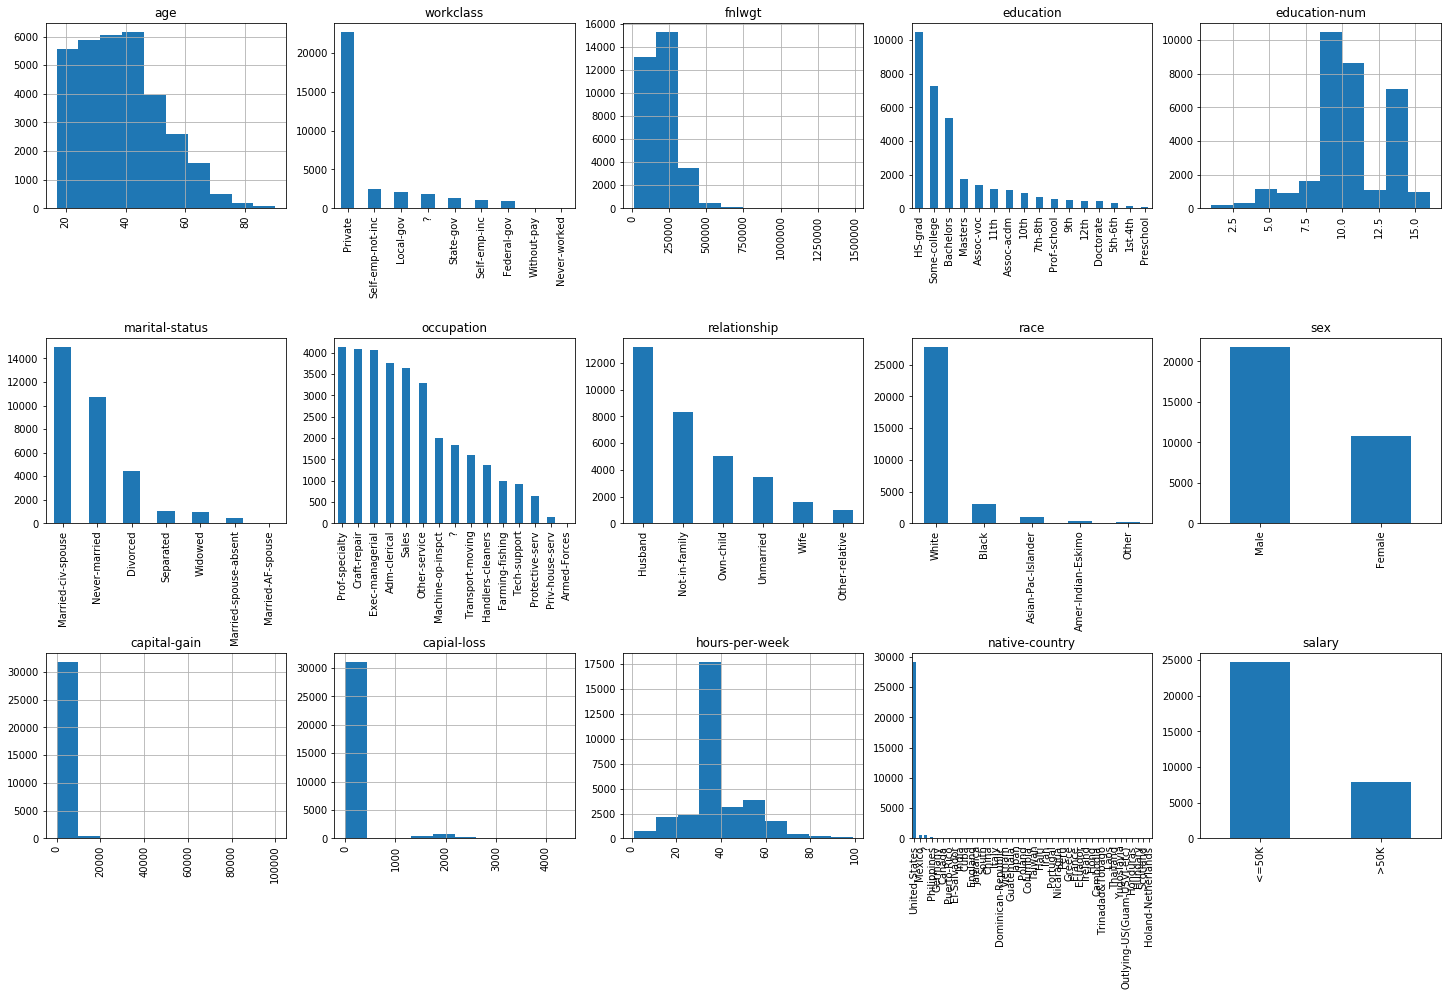

In [37]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = np.ceil(float(df.shape[1]) / cols)
for i, column in enumerate(df.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if df.dtypes[column] == np.object:
        df[column].value_counts().plot(kind="bar", axes=ax)
    else:
        df[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

Кодируем категориальные признаки 'Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'. Это можно сделать с помощью метода pandas get_dummies.

In [38]:
categorical_columns = [c for c in df.columns if df[c].dtype.name == 'object']
numerical_columns = [c for c in df.columns if df[c].dtype.name != 'object']
print(categorical_columns)
print(numerical_columns)

['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'salary']
['age', 'fnlwgt', 'education-num', 'capital-gain', 'capial-loss', 'hours-per-week']


In [39]:
for c in categorical_columns:
    df[c] = df[c].fillna(df[c].mode())
    
for c in numerical_columns:
    df[c] = df[c].fillna(df[c].median())

In [80]:
df2 = pd.concat([df.reset_index(drop=True), 
                pd.get_dummies(df['workclass'], prefix='workclass').reset_index(drop=True),
                pd.get_dummies(df['education'], prefix='education').reset_index(drop=True),
                pd.get_dummies(df['marital-status'], prefix='marital-status').reset_index(drop=True),
                pd.get_dummies(df['occupation'], prefix='occupation').reset_index(drop=True),
                pd.get_dummies(df['relationship'], prefix='relationship').reset_index(drop=True),
                pd.get_dummies(df['race'], prefix='race').reset_index(drop=True),
                pd.get_dummies(df['native-country'], prefix='native-country').reset_index(drop=True),
                pd.get_dummies(df['sex'], prefix='sex').reset_index(drop=True)
               ], axis=1, sort=True)

df2['salary'] = df2['salary'].map({'<=50K': 0, '>50K': 1})

df2 = df2.drop(['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country', 'sex'], axis=1)


In [81]:
df2.head()

,age,fnlwgt,education-num,capital-gain,capial-loss,hours-per-week,salary,workclass_?,workclass_Federal-gov,workclass_Local-gov,...,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,sex_Female,sex_Male
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [83]:
print(df2['salary'].values)
X = df2.drop('salary', axis=1)
y = df2['salary']

[0 0 0 ... 0 0 1]


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### 3.1. Дерево решений без настройки параметров
Обучите на имеющейся выборке дерево решений (DecisionTreeClassifier) максимальной глубины 3 и получите качество на тесте. Используйте параметр random_state = 17 для воспроизводимости результатов.

In [85]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=17, splitter='best')

In [86]:
predictions = tree.predict(X_test)
print(accuracy_score(y_test, predictions))

0.8409335175802242


### 3.2. Дерево решений с настройкой параметров
Обучите на имеющейся выборке дерево решений (DecisionTreeClassifier, опять random_state = 17 ). Максимальную глубину настройте на кросс-валидации с помощью GridSearchCV. Проведите 5-кратную кросс-валидацию

In [88]:
tree_params = {'max_depth': range(2, 11)}
tree = DecisionTreeClassifier()
tree_search = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1)
tree_search.fit(X_train, y_train)

print(tree_search.best_params_)
print(tree_search.best_score_)

{'max_depth': 10}
0.8566492628992629


In [89]:
best_tree = tree_search.best_estimator_
predictions = best_tree.predict(X_test)
print(accuracy_score(y_test, predictions))

0.8529095654844158


### 3.3. Случайный лес без настройки параметров (опционально)¶
Немного забежим вперед и попробуем в нашей задаче случайный лес. Пока можно его себе представлять, как куча деревьев решений, обученных на немного разных подвыборках исходной обучающей выборки, причем эта куча деревьев обычно работает существенно лучше, чем отдельные деревья.

Обучите на имеющейся выборке случайный лес (RandomForestClassifier), число деревьев сделайте равным ста, а random_state = 17.

In [90]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=17)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.8490710885920467


### 3.4. Случайный лес с настройкой параметров (опционально)
Обучите на имеющейся выборке случайный лес (RandomForestClassifier). Максимальную глубину и максимальное число признаков для каждого дерева настройте с помощью GridSearchCV.

In [91]:
rf = RandomForestClassifier(n_estimators=100, random_state=17)

In [ ]:
rf_params = {'max_depth':range(10, 21), 'max_features': range(5, 105, 10)}
rf_search = GridSearchCV(rf, rf_params, cv=5, n_jobs=-1)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
predictions = best_rf.predict(X_test)
print(accuracy_score(y_test, predictions))